# Kernelized Neural Process

Last Update : 13 June 2019

In [1]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = False # can also be set in the trainer

## Environment

In [2]:
cd ..

/master


In [3]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# CENTER PLOTS
from IPython.core.display import HTML
display(HTML(""" <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""))

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""

import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(N_THREADS)

Autosaving every 600 seconds


## Dataset

In this notebook I only look at the periodic and mattern kernel. See [Tutorial 1 - Conditional Neural Process] for more details.

[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb

In [4]:
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, DotProduct, ConstantKernel
from ntbks_viz import plot_posterior_samples, plot_prior_samples, plot_dataset_samples

from ntbks_datasets import GPDataset

In [5]:
X_DIM = 1  # 1D spatial input
Y_DIM = 1  # 1D regression
N_POINTS = 128
N_SAMPLES = 100000 # this is a lot and can work with less

In [6]:
datasets = dict()
kwargs = dict(n_samples=N_SAMPLES, n_points=N_POINTS)
datasets["rbf"] = GPDataset(kernel=1.0 * RBF(length_scale=1.0,
                                             length_scale_bounds=(1e-1, 10.0)),
                            **kwargs)

datasets["periodic"] = GPDataset(kernel=1.0 * ExpSineSquared(length_scale=1.0,
                                                             periodicity=3.0,
                                                             length_scale_bounds=(0.1, 10.0),
                                                             periodicity_bounds=(1.0, 10.0)),
                                 **kwargs)
datasets["non-stationary"] = GPDataset(kernel=(ConstantKernel(0.1, (0.01, 10.0)) *
                                               (DotProduct(sigma_0=1.0,
                                                           sigma_0_bounds=(0.1, 10.0)) ** 2)),
                                       **kwargs)
datasets["matern"] = GPDataset(kernel=1.0 * Matern(length_scale=1.0,
                                                   length_scale_bounds=(1e-1, 10.0),
                                                   nu=1.5),
                               **kwargs)

## Model


In [7]:
from torch.distributions import Normal

from skssl.transformers import (NeuralProcessLoss, NeuralProcess, AttentiveNeuralProcess, 
                                SelfAttentionBlock, SinusoidalEncodings, FeatureEncodings)
from skssl.predefined import MLP, merge_flat_input, get_uninitialized_mlp
from skssl.transformers.neuralproc.datasplit import context_target_split

In [8]:
R_DIM = 64
RANGE_CNTXT = (4, 50)  # context points will be sampled uniformly in this range
RANGE_EXTRA_TRGTS = (3, N_POINTS-RANGE_CNTXT[1])  # extra number of targtes points 

In [9]:
def get_cntxt_trgt(*args):
    return context_target_split(*args, range_cntxts=RANGE_CNTXT, range_extra_trgts=RANGE_EXTRA_TRGTS)

def init_model():
    return AttentiveNeuralProcess(X_DIM, Y_DIM,
                         XEncoder=FeatureEncodings, 
                         XYEncoder=merge_flat_input(get_uninitialized_mlp(n_hidden_layers=2),
                                                    is_sum_merge=False),  
                         Decoder=merge_flat_input(get_uninitialized_mlp(n_hidden_layers=5),
                                                  is_sum_merge=False),  # no self attention encoder 
                         r_dim=R_DIM,
                         get_cntxt_trgt=get_cntxt_trgt,
                         aggregator=torch.mean,
                         PredictiveDistribution=Normal, 
                         LatentEncoder=MLP,
                         x_transf_dim=8,
                          attention="weighted_dist", # parameter free attention because simple task
                          encoded_path="deterministic", # use both latent  and deterministic path as in paper
                         is_normalize=False)

In [10]:
# initialize one model for each dataset
data_models = {name: (init_model(), data) 
               for name, data in datasets.items()}

### N Param

Number of parameters (note that I did not play around with this much, this depends a lot on the representation size):

In [11]:
from utils.helpers import count_parameters

In [12]:
for k, (neural_proc, dataset) in data_models.items():
    print("N Param:", count_parameters(neural_proc))
    break

N Param: 10229


The increase of parameters doesn't come from attention (as the attention is parameter free in this case), but from the fact that we have a deterministic and a latent path. Using only a deterministic path, the model can be very small. See the following notebook to see such a model with only 35682 parameters : [Small Multihead Conditional Attentive Neural Process]

[Small Multihead Conditional Attentive Neural Process]: Small%20Multihead%20Conditional%20Attentive%20Neural%20Process.ipynb

## Training

In [13]:
from skorch.callbacks import ProgressBar, Checkpoint

from skssl.training import NeuralNetTransformer
from skssl.training.helpers import make_Xy_input

Nota Bene: using a small batch size is probably important as we use fix amount of context in batch, and with attention you don't have aggregation => the number of context points changes the attention mechanism (the softmax) => use small to have many different number of context points but we want a fair comparison so keep `learning rate=1e-3` and `batch_size=64` like other notebook.

In [14]:
N_EPOCHS = 30 # 30 is enough
BATCH_SIZE = 64 
is_RETRAIN = True # if false load precomputed

In [15]:
for k,(neural_proc, dataset) in data_models.items():
    print()
    print("--- {} {} ---".format("Training" if is_RETRAIN else "Loading", k))
    print()
    
    chckpt = Checkpoint(dirname="results/notebooks/neural_process/mini_kcnp_{}".format(k), 
                        monitor='train_loss_best') # train would be same as validation as always resamples
    
    model = NeuralNetTransformer(neural_proc, NeuralProcessLoss,
                                 max_epochs=N_EPOCHS,
                                 batch_size=BATCH_SIZE,
                                 train_split=None,  # don't use cross validation dev set
                                 lr=1e-3, # they use 5e-5 because 16 batch size but that would be slow
                                 callbacks=[ProgressBar(), 
                                            chckpt], # checkpoint best model
                                ) 
    
    if is_RETRAIN:
        if dataset == "rbf":
            model.initialize()
            model.load_params(checkpoint=chckpt)
        _=model.fit(*make_Xy_input(dataset))
    
    # load in all case => even when training loads the best checkpoint
    model.initialize()
    model.load_params(checkpoint=chckpt)


--- Training rbf ---



  epoch    train_loss    cp      dur
-------  ------------  ----  -------
      1      887.1436     +  22.3972


      2      206.7380     +  23.1375


      3      188.2574     +  23.2694


      4      459.0650        22.7781


      5      174.9641     +  23.5680


      6      161.3052     +  23.7816


      7      154.0233     +  24.2919


      8      146.5081     +  24.4018


      9      139.2046     +  23.9502


     10      130.6720     +  23.5745


     11      121.9263     +  22.9961


     12      113.2419     +  23.0951


     13      106.7004     +  23.8759


     14       98.8357     +  23.5245


     15       89.2060     +  23.2728


     16       80.9064     +  23.7102


     17       75.3710     +  23.4823


     18       72.5613     +  22.9413


     19       69.0672     +  23.7935


     20       66.0947     +  23.4996


     21       62.7988     +  23.1433


     22       59.9627     +  23.2158


     23       56.4685     +  23.4736


     24       53.8382     +  23.5693


     25       49.7906     +  23.6342


     26       49.3162     +  22.5839


     27       46.1425     +  23.3918


     28       46.3874        23.5744


     29       44.2653     +  23.1024


     30       40.5415     +  23.2093
Re-initializing optimizer because the following parameters were re-set: .

--- Training periodic ---



  epoch    train_loss    cp      dur
-------  ------------  ----  -------
      1    26154.6938     +  23.4404


      2      696.7182     +  23.5252


      3      706.8093        23.3042


      4      773.7000        22.9607


      5     3022.8341        23.4648


      6    25437.2825        23.6279


      7     1159.0515        24.0285


      8     1150.5094        22.8597


      9     1125.4769        22.6459


     10     2555.1043        23.3585


     11     1676.2940        23.7513


     12     1281.4042        23.3253


     13    50325.7242        22.8486


     14     1417.6594        24.1707


     15   448866.4544        23.6614


     16     1454.9170        24.2863


     17   156249.0569        23.1462


     18     1037.7354        23.8823


     19     1018.0788        23.6557


Re-initializing optimizer because the following parameters were re-set: .

--- Training non-stationary ---



Re-initializing optimizer because the following parameters were re-set: .

--- Training matern ---



Re-initializing optimizer because the following parameters were re-set: .


# Trained Prior

In [18]:
EXTRAP_DISTANCE = 2  # add 2 to the right for extrapolation
INTERPOLATION_RANGE = dataset.min_max
EXTRAPOLATION_RANGE = (dataset.min_max[0], dataset.min_max[1]+EXTRAP_DISTANCE )

std: 1.1032460683584209
std: 0.361180245578289
std: 4.19652947038412
std: 0.13893655464053148


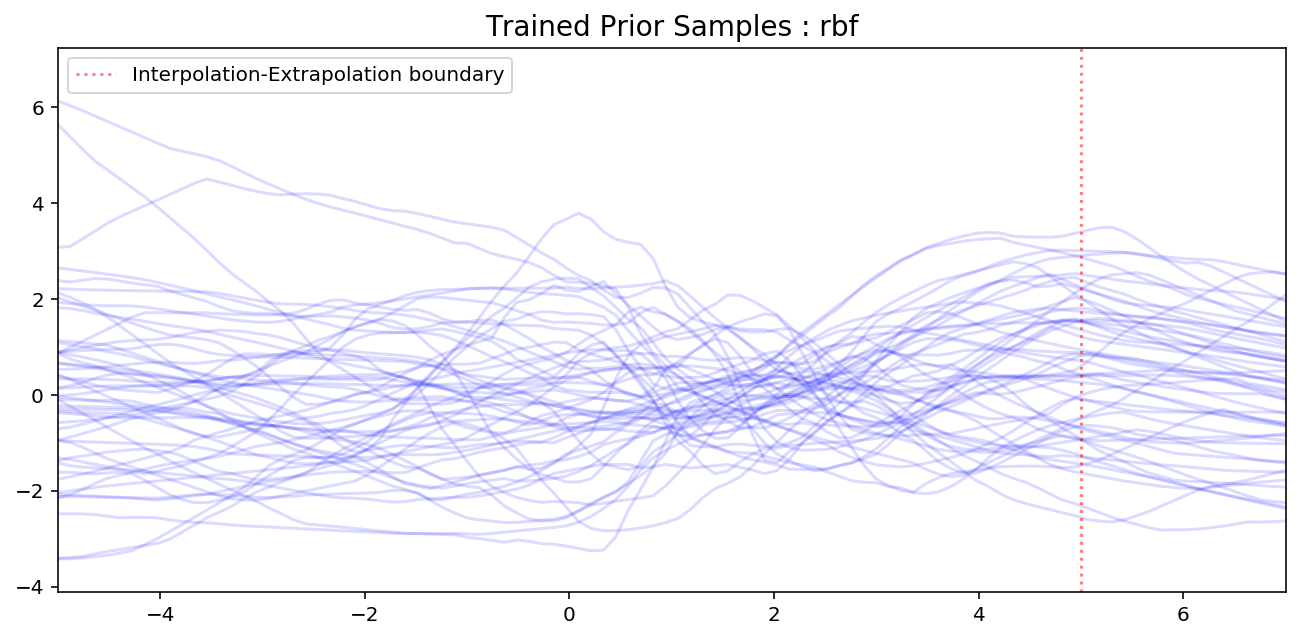

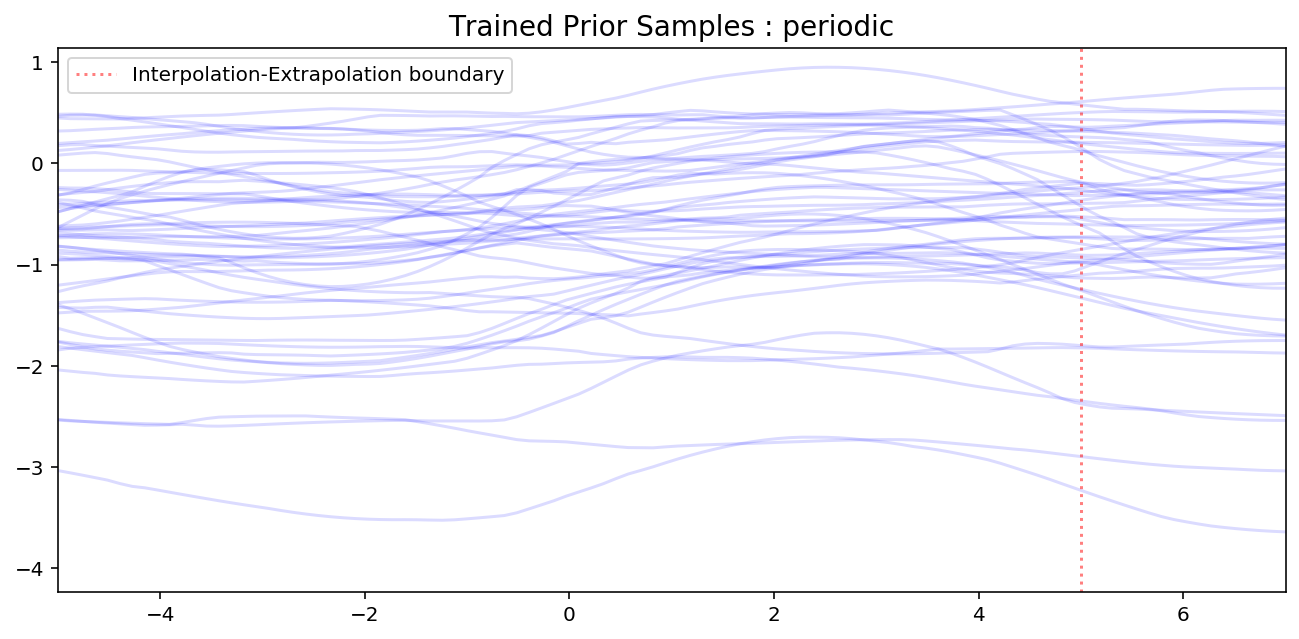

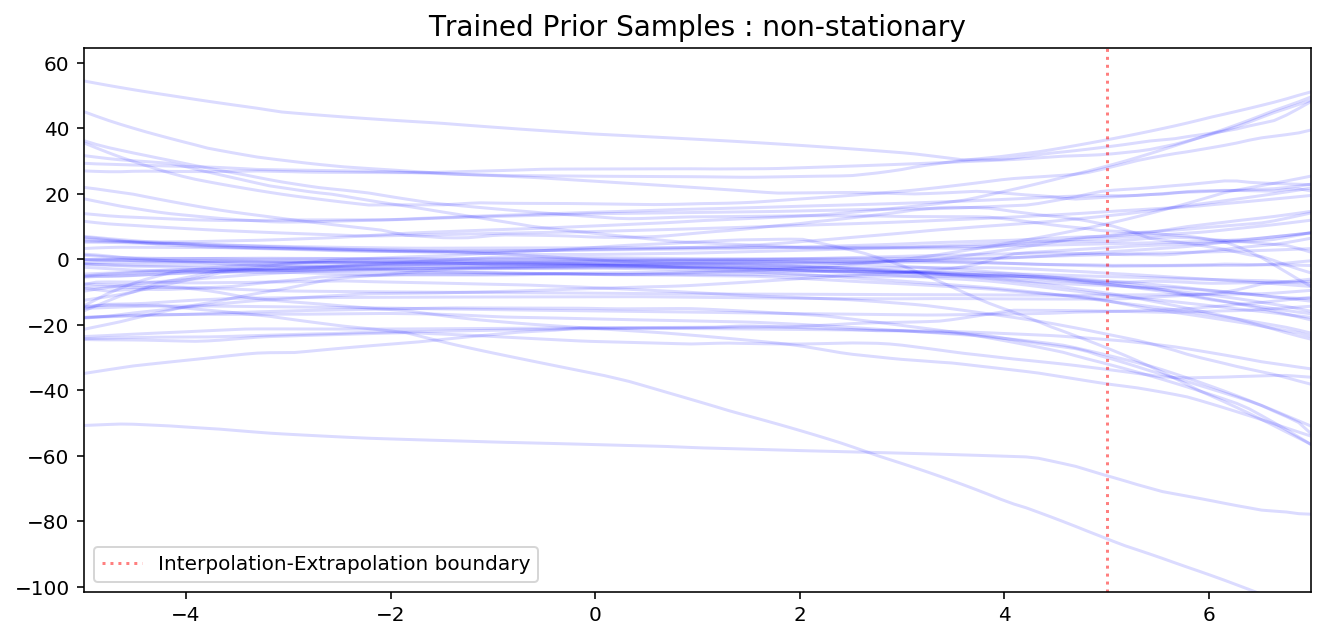

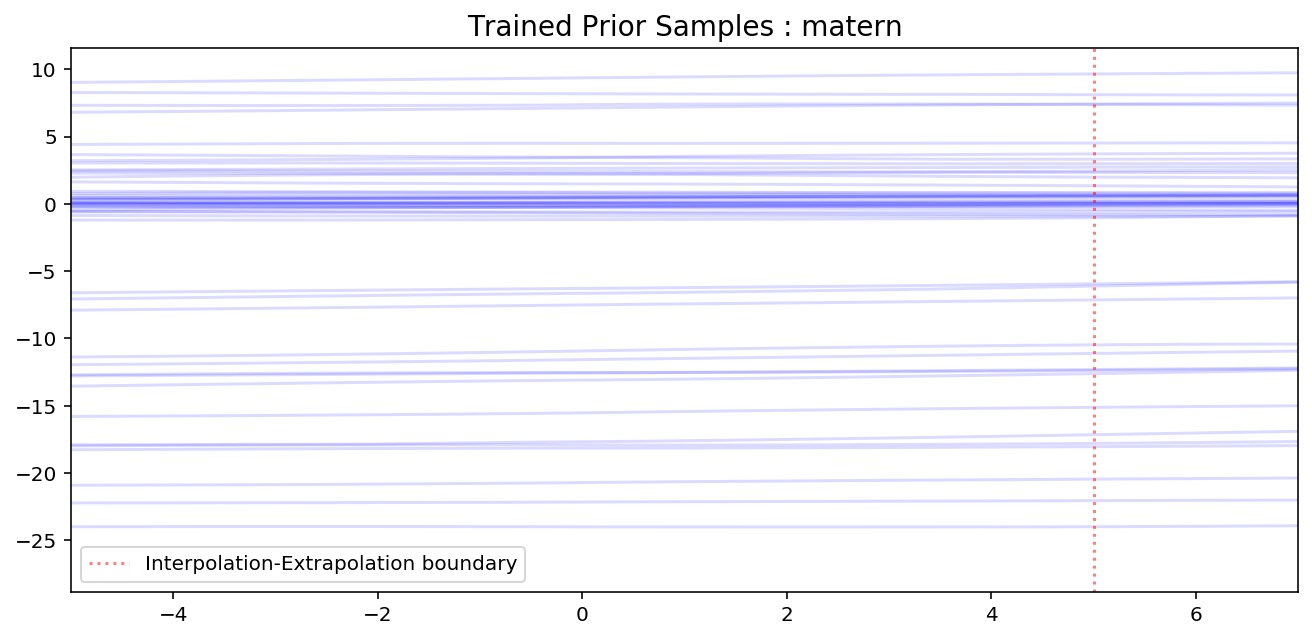

In [19]:
for k,(neural_proc, dataset) in data_models.items():
    plot_prior_samples(neural_proc, 
                       title="Trained Prior Samples : {}".format(k), 
                       test_min_max=EXTRAPOLATION_RANGE, 
                       train_min_max=INTERPOLATION_RANGE)

# Posterior

std: 0.8700398206710814
std: 25.55166053771973
std: 1027.1491699218755
std: 0.10000001639127731


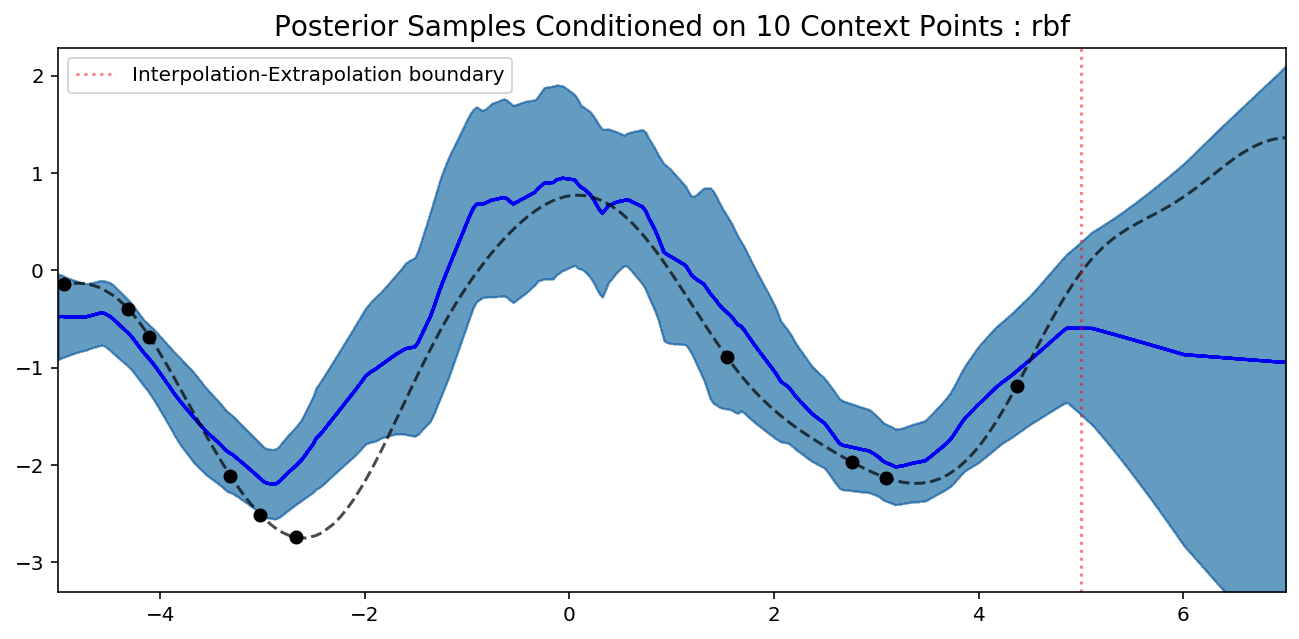

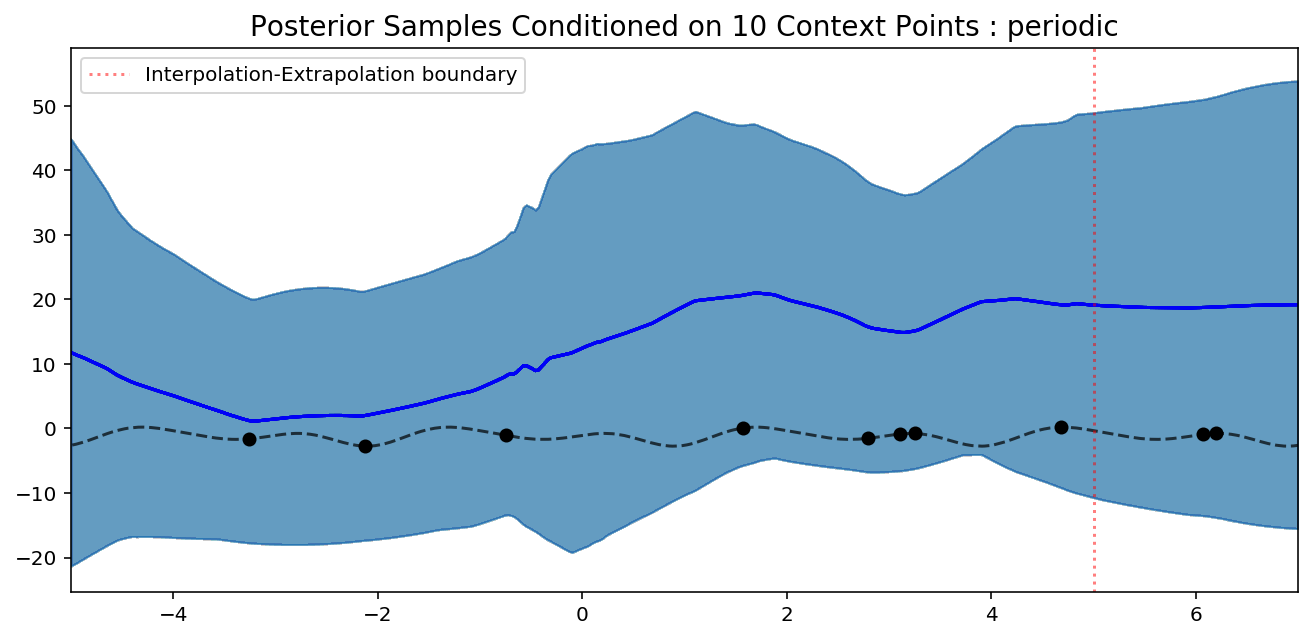

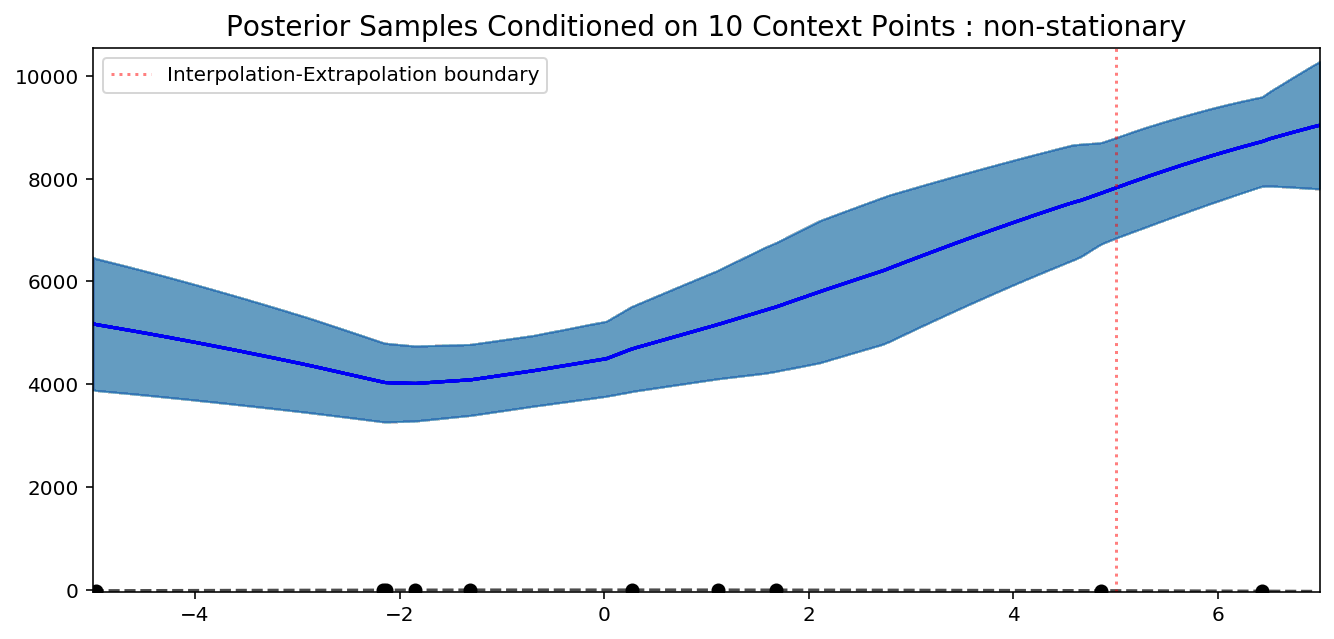

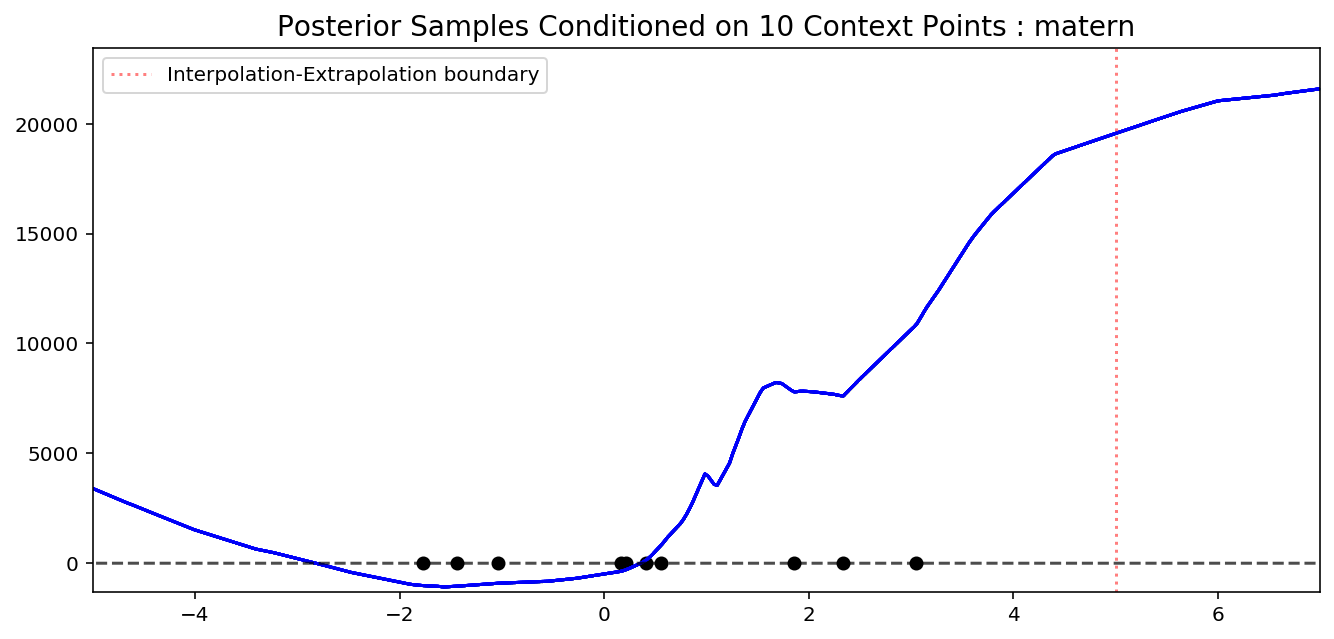

In [20]:
N_CNTXT = 10
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=400,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

In [ ]:
N_CNTXT = 2
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=2*N_POINTS,
                           n_samples=30,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

In [ ]:
N_CNTXT = 20
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=2*N_POINTS,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

In [ ]:
N_CNTXT = 1
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=2*N_POINTS,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

We see that the predictions are much better than in [Tutorial 2 - Neural Process]

**Good**:
- the sampled function all go through or close to the context points
- the uncertainty decreases close to context points
- the samples all seem relatively different (not linear shifts like in [Tutorial 2 - Neural Process])

**Bad**:
- there seems to always be a strange "jump" in the middle of region between 2 far points. This is probably due to the softmax in cross attention, and disappears when using multihead attention. 
- cannot extrapolate and not even give high uncertainty when extrapolating

[Tutorial 2 - Neural Process]: Tutorial%202%20-%20Neural%20Process.ipynb

In [25]:
a = torch.linspace(0,1,6).view(3,1,2)
b = torch.linspace(0,1,8).view(1,4,2)

In [26]:
torch.dist(a,b)

tensor(2.2424)

In [27]:
torch.norm(a-b, p=2, dim=-1)

tensor([[0.0571, 0.3659, 0.7688, 1.1725],
        [0.6074, 0.2060, 0.2060, 0.6074],
        [1.1725, 0.7688, 0.3659, 0.0571]])

In [34]:
keys = torch.randn(2,3,4).cuda()
keys

tensor([[[-1.0947, -0.1483,  0.4502, -0.3304],
         [ 1.0060, -0.1371, -0.2893, -0.1191],
         [-0.6651,  1.0364,  0.7535,  1.4348]],

        [[-1.5505,  0.9697, -1.8695, -1.1548],
         [-0.1538, -0.9391,  0.0099, -0.2061],
         [ 1.1512, -0.6192,  0.6877, -0.8079]]], device='cuda:0')

In [38]:
augmented_keys = torch.cat([keys, torch.ones(1, device=keys.device).expand_as(keys)], dim=-1)

In [39]:
augmented_keys.shape

torch.Size([2, 3, 8])

In [43]:
torch.bmm(torch.ones(5,4,2,3), torch.ones(5,3,2,1)).shape

RuntimeError: Expected 3-dimensional tensor, but got 4-dimensional tensor for argument #1 'batch1' (while checking arguments for bmm)

In [48]:
torch.nn.LayerNorm(5).__dict__

{'_backend': <torch.nn.backends.thnn.THNNFunctionBackend at 0x7f6e4a84f2b0>,
 '_parameters': OrderedDict([('weight', Parameter containing:
               tensor([1., 1., 1., 1., 1.], requires_grad=True)),
              ('bias', Parameter containing:
               tensor([0., 0., 0., 0., 0.], requires_grad=True))]),
 '_buffers': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_modules': OrderedDict(),
 'training': True,
 'normalized_shape': torch.Size([5]),
 'eps': 1e-05,
 'elementwise_affine': True}

In [54]:
torch.nn.Parameter

torch.nn.parameter.Parameter

In [57]:
torch.nn.functional.normalize()

TypeError: normalize() missing 1 required positional argument: 'input'